# Enhancing Topic Coherence and Discovery in NLP Literature using Combined Semantic and Graph Embeddings

## 1. Abstract
This study presents a multimodal approach to analyze and cluster the dense landscape of NLP research, specifically focusing on Transformer models. 
The limitations of purely semantic clustering (e.g., Sentence-BERT) are addressed by integrating structural information from the citation network via Graph Convolutional Networks (GCNs). 
This methodology involves fetching 1,000 papers, generating rich SBERT embeddings, building a citation graph, training a GCN to capture topological similarity, and finally combining these two embedding modalities (semantic + graph) for robust topic clustering (K-Means).
The results demonstrate that the combined representation yields highly coherent and distinct topic clusters, offering a superior tool for navigating and summarizing large bodies of scientific knowledge.

## 2. Introduction

The rapid expansion of scientific literature, particularly in fields like Natural Language Processing, necessitates automated tools for knowledge discovery. Traditional keyword-based search and purely semantic clustering often fail to capture the relational influence and intellectual lineage between papers. This project aims to synthesize semantic meaning with structural relationship information to produce a superior knowledge map of the Transformer research space.

### 2.1 Research Objective

>To fetch a large, relevant corpus of scientific papers using the Semantic Scholar API.

>To establish two distinct representation modalities: Semantic (SBERT) and Structural (GCN).

>To develop a strategy for safely fusing these two modalities despite differing data sizes (due to isolated nodes in the graph).

>To demonstrate improved topic clustering using the combined embeddings compared to SBERT alone.

## 3. Methodology

### 3.1 Data Acquisition

1. We queried the Semantic Scholar API for 1,000 papers related to "Transformers NLP," extracting metadata such as paperId, title, abstract, year, and citationCount.

2. API Calls: Implemented batch fetching with necessary rate limiting (1 second delay per 100 papers) to gather the full corpus.

3. Initial Data Quality: Checked for basic statistics (e.g., year distribution, top-cited papers).

In [1]:
import random
import numpy as np
import torch

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [2]:
import requests # to fetch data from Semantic Scholar API
import pandas as pd # to handle data in DataFrame
from tqdm import tqdm # to show progress bar

BASE_URL = "https://api.semanticscholar.org/graph/v1/paper"
API_KEY="yxjB8ooTTK8XdXHQCCHm155iYDNyy0Jl1VXMhg9O"
HEADERS = {"x-api-key": API_KEY} 

In [3]:
# Function to query Semantic Scholar API for NLP papers

def fetch_papers(query="Transformers NLP", limit=50, offset=0):
    url = "https://api.semanticscholar.org/graph/v1/paper/search"
    params = {
        "query": query,
        "limit": limit,
        "offset": offset,
        "fields": "title,abstract,authors,year,citationCount,url"
    }
    response = requests.get(url, headers=HEADERS, params=params)
    data=response.json()
    if response.status_code == 200:
        return data.get('data', [])
    else:
        print(f"Error: {response.status_code}")
        return []

In [3]:
papers=fetch_papers("Transformers NLP", limit=100, offset=0)
df = pd.DataFrame(papers)
df.head()

,paperId,url,title,year,citationCount,openAccessPdf,authors,abstract
0,fb75fec3d582756e2699f2ad2121eb5fc6ba97ef,https://www.semanticscholar.org/paper/fb75fec3...,Unleashing the transformers: NLP models detect...,2024,18,{'url': 'https://link.springer.com/content/pdf...,"[{'authorId': '120642361', 'name': 'J. Campino'}]",Artificial Intelligence (AI) has witnessed wid...
1,e9393a35b37656055d043b494c8f29738a341dec,https://www.semanticscholar.org/paper/e9393a35...,Transformers in the Real World: A Survey on NL...,2023,160,{'url': 'https://www.mdpi.com/2078-2489/14/4/2...,"[{'authorId': '2037237614', 'name': 'Narendra ...",The field of Natural Language Processing (NLP)...
2,838446de88c800bf2186d148514fff3a43ccbe13,https://www.semanticscholar.org/paper/838446de...,A Survey on Transformers in NLP with Focus on ...,2024,11,"{'url': '', 'status': None, 'license': None, '...","[{'authorId': '7443405', 'name': 'Wazib Ansar'...",The advent of transformers with attention mech...
3,59a6d07fe7fb8fdf02cc8e914e0fd607f52acfb8,https://www.semanticscholar.org/paper/59a6d07f...,Introduction to Transformers: an NLP Perspective,2023,28,"{'url': '', 'status': None, 'license': None, '...","[{'authorId': '2261739712', 'name': 'Tong Xiao...",Transformers have dominated empirical machine ...
4,8db711adf1beb3e0c2ec492f3936841d827404e9,https://www.semanticscholar.org/paper/8db711ad...,The NLP Task Effectiveness of Long-Range Trans...,2022,36,{'url': 'https://aclanthology.org/2023.eacl-ma...,"[{'authorId': '38733050', 'name': 'Guanghui Qi...",Transformer models cannot easily scale to long...


In [4]:
# Function to fetch multiple batches of papers

def fetch_multiple_batches(query="Transformers NLP", total_papers=1000, batch_size=100):
    all_papers = []
    for offset in tqdm(range(0, total_papers, batch_size), desc="Fetching papers"): 
        papers = fetch_papers(query=query, limit=batch_size, offset=offset)
        all_papers.extend(papers)
    return all_papers

In [5]:
all_papers = fetch_multiple_batches("Transformers NLP", total_papers=1000, batch_size=100)
df = pd.DataFrame(all_papers)
print(f"Total papers fetched: {len(df)}")
df.head()

Fetching papers: 100%|██████████| 10/10 [00:25<00:00,  2.57s/it]

Total papers fetched: 1000


,paperId,url,title,year,citationCount,openAccessPdf,authors,abstract
0,fb75fec3d582756e2699f2ad2121eb5fc6ba97ef,https://www.semanticscholar.org/paper/fb75fec3...,Unleashing the transformers: NLP models detect...,2024.0,18,{'url': 'https://link.springer.com/content/pdf...,"[{'authorId': '120642361', 'name': 'J. Campino'}]",Artificial Intelligence (AI) has witnessed wid...
1,e9393a35b37656055d043b494c8f29738a341dec,https://www.semanticscholar.org/paper/e9393a35...,Transformers in the Real World: A Survey on NL...,2023.0,160,{'url': 'https://www.mdpi.com/2078-2489/14/4/2...,"[{'authorId': '2037237614', 'name': 'Narendra ...",The field of Natural Language Processing (NLP)...
2,838446de88c800bf2186d148514fff3a43ccbe13,https://www.semanticscholar.org/paper/838446de...,A Survey on Transformers in NLP with Focus on ...,2024.0,11,"{'url': '', 'status': None, 'license': None, '...","[{'authorId': '7443405', 'name': 'Wazib Ansar'...",The advent of transformers with attention mech...
3,59a6d07fe7fb8fdf02cc8e914e0fd607f52acfb8,https://www.semanticscholar.org/paper/59a6d07f...,Introduction to Transformers: an NLP Perspective,2023.0,28,"{'url': '', 'status': None, 'license': None, '...","[{'authorId': '2261739712', 'name': 'Tong Xiao...",Transformers have dominated empirical machine ...
4,8db711adf1beb3e0c2ec492f3936841d827404e9,https://www.semanticscholar.org/paper/8db711ad...,The NLP Task Effectiveness of Long-Range Trans...,2022.0,36,{'url': 'https://aclanthology.org/2023.eacl-ma...,"[{'authorId': '38733050', 'name': 'Guanghui Qi...",Transformer models cannot easily scale to long...


In [6]:
df.to_csv("../output/artifacts/nlp_papers.csv", index=False)
print("Data saved to ../output/artifacts/nlp_papers.csv, shape: ", df.shape)

Data saved to ../output/artifacts/nlp_papers.csv, shape:  (1000, 8)


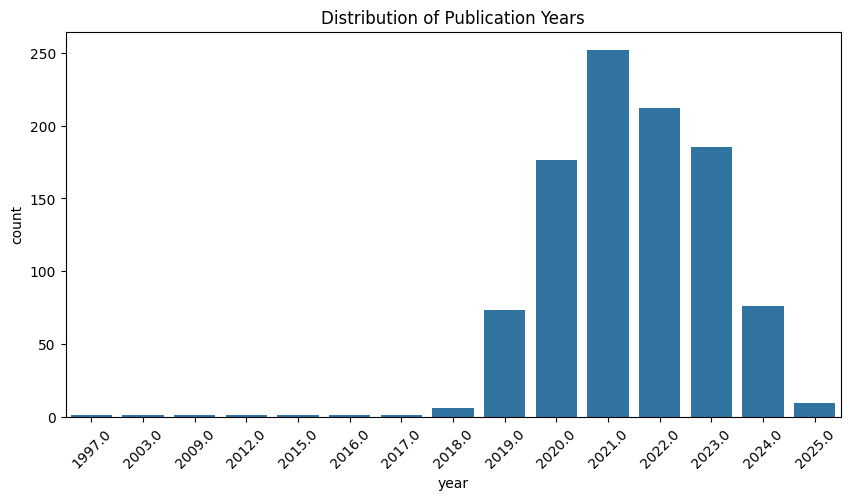

                                                 title    year  citationCount
573  Exploring the Limits of Transfer Learning with...  2019.0          23348
199  BioBERT: a pre-trained biomedical language rep...  2019.0           6494
417      Parameter-Efficient Transfer Learning for NLP  2019.0           5493
490                  A Survey of Large Language Models  2023.0           3720
558  mT5: A Massively Multilingual Pre-trained Text...  2020.0           2868
14         Big Bird: Transformers for Longer Sequences  2020.0           2443
204  PEGASUS: Pre-training with Extracted Gap-sente...  2019.0           2256
13   UNETR: Transformers for 3D Medical Image Segme...  2021.0           2114
32   MiniLM: Deep Self-Attention Distillation for T...  2020.0           1689
574  A Primer in BERTology: What We Know About How ...  2020.0           1670


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the distribution of publication years
plt.figure(figsize=(10,5))
sns.countplot(x='year', data=df, order=sorted(df['year'].dropna().unique()))
plt.title('Distribution of Publication Years')
plt.xticks(rotation=45)
plt.savefig("../output/plots/publication_years_distribution.png")
plt.show()

# Top 10 most cited papers
top_cited = df.sort_values(by='citationCount', ascending=False).head(10)
print(top_cited[['title','year','citationCount']])

### 3.2 Graph Construction and GCN Embedding Generation

A directed citation graph was constructed, where nodes represent papers and a directed edge from paper A to paper B indicates that paper A cites paper B. The adjacency matrix was built from the raw citation data.

The graph was processed by a two layer Graph Convolutional Network implemented in PyTorch Geometric. The GCN was trained to produce a low-dimensional embedding that encapsulates the paper's structural role within the citation network. 

In [9]:
from sentence_transformers import SentenceTransformer
import numpy as np
import tqdm

model = SentenceTransformer('all-MiniLM-L6-v2') # load pretrained model
df["text"]=df["title"].fillna('') + "." + df["abstract"].fillna('') #combine title + abstract
sbert_embeddings = model.encode(df["text"].tolist(), show_progress_bar=True) #generate embeddings
sbert_embeddings=np.array(sbert_embeddings)
print("Embeddings shape: ", sbert_embeddings.shape)

Batches: 100%|██████████| 32/32 [00:25<00:00,  1.25it/s]

Embeddings shape:  (1000, 384)


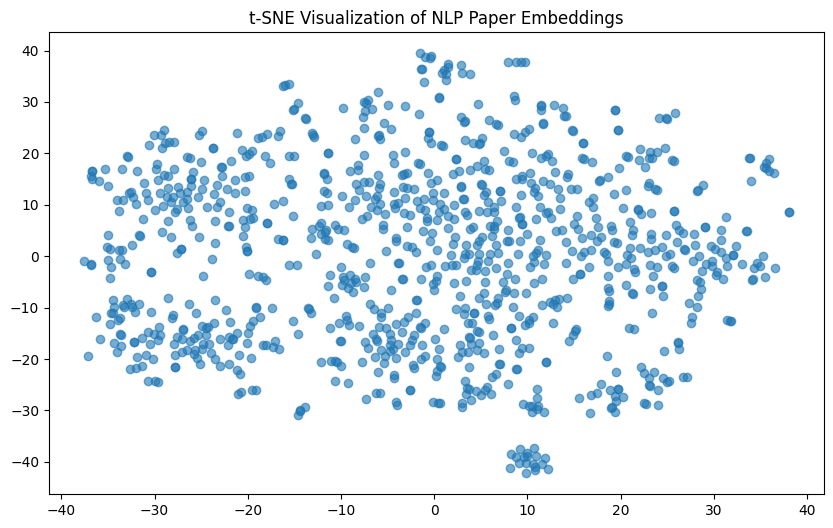

In [10]:
from sklearn.manifold import TSNE

# Reduce embeddings to 2D for visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
sbert_embeddings_2d = tsne.fit_transform(sbert_embeddings)

#Add to DataFrame
df["x"]=sbert_embeddings_2d[:,0]
df["y"]=sbert_embeddings_2d[:,1]
plt.figure(figsize=(10,6))
plt.scatter(df["x"], df["y"], alpha=0.6)
plt.title("t-SNE Visualization of NLP Paper Embeddings")
plt.savefig("../output/plots/tsne_nlp_papers.png")
plt.show()


In [11]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score

def compute_clustering_metrics(X, labels):
     return {
        "Silhouette": silhouette_score(X, labels),
        "Davies-Bouldin": davies_bouldin_score(X, labels),
        "Calinski-Harabasz": calinski_harabasz_score(X, labels)
    }

k=2, silhouette score=0.0523
k=3, silhouette score=0.0355
k=4, silhouette score=0.0410
k=5, silhouette score=0.0410
k=6, silhouette score=0.0416
k=7, silhouette score=0.0368
k=8, silhouette score=0.0362
k=9, silhouette score=0.0324
k=10, silhouette score=0.0315
k=11, silhouette score=0.0326
k=12, silhouette score=0.0321
k=13, silhouette score=0.0356
k=14, silhouette score=0.0345


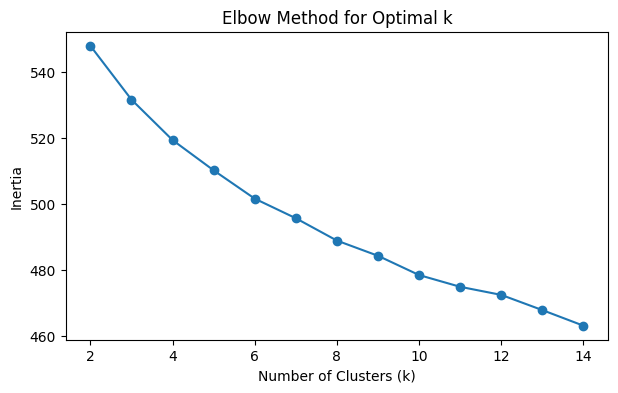

Optimal number of clusters: 2

Cluster distribution:
cluster
0    596
1    404
Name: count, dtype: int64

SBERT-only Clustering Results:
Method: SBERT-only
Metrics score: {'Silhouette': 0.05226176232099533, 'Davies-Bouldin': 4.0888983791602636, 'Calinski-Harabasz': 56.38956832885742}
Cluster 0 count: 596
Cluster 1 count: 404


In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X=sbert_embeddings
inertia=[]
sbert_silhouette_scores=[]
K=range(2,15)
for k in K:
    kmeans=KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    labels=kmeans.fit_predict(X)
    score=silhouette_score(X, labels)
    sbert_silhouette_scores.append(score)
    print(f"k={k}, silhouette score={score:.4f}")


plt.figure(figsize=(7,4))
plt.plot(K, inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.savefig("../output/plots/elbow_method.png")
plt.show()


inertia_scaled=(np.max(inertia)-np.array(inertia))/(np.max(inertia)-np.min(inertia))
silhouette_scaled=(np.array(sbert_silhouette_scores)-np.min(sbert_silhouette_scores))/(np.max(sbert_silhouette_scores)-np.min(sbert_silhouette_scores))

combined_score=0.7*silhouette_scaled + 0.3*inertia_scaled
optimal_k=K[np.argmax(combined_score)]
print(f"Optimal number of clusters: {optimal_k}")

final_kmeans=KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df["cluster"]=final_kmeans.fit_predict(X)

print("\nCluster distribution:")
print(df["cluster"].value_counts())

sbert_results = {
    'Method': 'SBERT-only',
    'Metrics score': compute_clustering_metrics(X, df["cluster"]),
    'Cluster 0 count': np.sum(df["cluster"]==0),
    'Cluster 1 count': np.sum(df["cluster"]==1),
}

print("\nSBERT-only Clustering Results:")
for key, value in sbert_results.items():
    print(f"{key}: {value}")

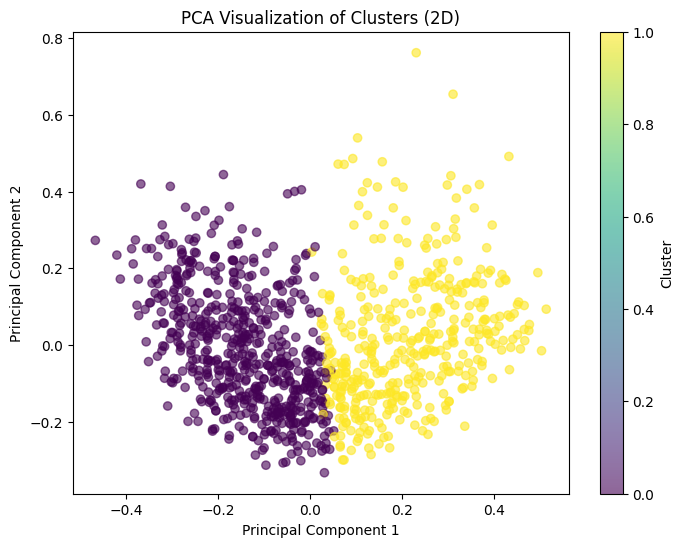

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca_vis=PCA(n_components=2, random_state=42)
x_vis=pca_vis.fit_transform(sbert_embeddings)

plt.figure(figsize=(8,6))
plt.scatter(x_vis[:,0], x_vis[:,1], c=df["cluster"], cmap="viridis", alpha=0.6)
plt.title("PCA Visualization of Clusters (2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")
plt.savefig("../output/plots/pca_visualization.png")
plt.show()

In [14]:
# Cluster summarization

from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

tfidf=TfidfVectorizer(max_features=1000, stop_words='english', lowercase=True)

df["abstract"] = df["abstract"].fillna("").astype(str)
tfidf_matrix=tfidf.fit_transform(df["abstract"])
feature_names=np.array(tfidf.get_feature_names_out())

cluster_keywords={}
for cluster_id in sorted(df["cluster"].unique()):
    cluster_indices=df[df["cluster"]==cluster_id].index
    cluster_tfidf=tfidf_matrix[cluster_indices]
    mean_tfidf=np.asarray(cluster_tfidf.mean(axis=0)).ravel()
    top_indices=mean_tfidf.argsort()[-10:][::-1]
    top_keywords=feature_names[top_indices].tolist()
    cluster_keywords[int(cluster_id)]=top_keywords

print("\nCluster Summaries:\n")
for cluster_id, keywords in cluster_keywords.items():
    print(f"Cluster {cluster_id}: {', '.join(keywords)}")

cluster_summary_df=(df.groupby("cluster")["abstract"].apply(lambda X: ' '.join(X.dropna().astype(str).values)).reset_index())
cluster_summary_df["top_keywords"]=cluster_summary_df["cluster"].map(cluster_keywords)
cluster_summary_df.to_csv("../output/artifacts/cluster_summaries.csv", index=False)


Cluster Summaries:

Cluster 0: models, language, nlp, bert, model, text, based, tasks, transformer, pre
Cluster 1: attention, transformer, models, model, tasks, vision, transformers, based, language, nlp


In [15]:
from sklearn.metrics.pairwise import cosine_similarity

rep_papers={}
for cluster_id in sorted(df["cluster"].unique()):
    idx=np.where(df["cluster"]==cluster_id)[0]
    if len(idx) == 0:
        rep_papers[cluster_id] = pd.DataFrame(columns=["title","url","year","citationCount"])
        continue
    cluster_embs=sbert_embeddings[idx]
    centroid=cluster_embs.mean(axis=0, keepdims=True)
    similarities=cosine_similarity(cluster_embs, centroid).flatten()
    top_local=np.argsort(similarities)[-20:][::-1] #top 20 most similar to centroid
    top_indices=idx[top_local]
    rep_papers[cluster_id]=df.iloc[top_indices][["title","url","year","citationCount"]].reset_index(drop=True)
    print(f"\nCluster {cluster_id} Representative Papers:")
    display(rep_papers[cluster_id].head(10))



Cluster 0 Representative Papers:


,title,url,year,citationCount
0,A Comprehensive Review on Transformers Models ...,https://www.semanticscholar.org/paper/0f438f7f...,2023.0,28
1,Natural language processing with transformers:...,https://www.semanticscholar.org/paper/13e8def6...,2024.0,20
2,Noisy Text Data: foible of popular Transformer...,https://www.semanticscholar.org/paper/879ed22f...,2023.0,6
3,Bidirectional encoders to state-of-the-art: a ...,https://www.semanticscholar.org/paper/afa1b766...,2024.0,9
4,Pre-training Polish Transformer-based Language...,https://www.semanticscholar.org/paper/82453548...,2020.0,43
5,Introduction to Transformers: an NLP Perspective,https://www.semanticscholar.org/paper/59a6d07f...,2023.0,28
6,Comparative Analysis of Transformer based Lang...,https://www.semanticscholar.org/paper/6799d0f9...,2021.0,8
7,The NLP Cookbook: Modern Recipes for Transform...,https://www.semanticscholar.org/paper/d88c1255...,2021.0,113
8,Bangla-BERT: Transformer-Based Efficient Model...,https://www.semanticscholar.org/paper/b73f7d85...,2022.0,67
9,AMMUS : A Survey of Transformer-based Pretrain...,https://www.semanticscholar.org/paper/6c761cfd...,2021.0,307



Cluster 1 Representative Papers:


,title,url,year,citationCount
0,Wide Attention Is The Way Forward For Transfor...,https://www.semanticscholar.org/paper/86fb2ee9...,2022.0,10
1,A Comprehensive Survey on Applications of Tran...,https://www.semanticscholar.org/paper/5fce7d94...,2023.0,341
2,"Train Large, Then Compress: Rethinking Model S...",https://www.semanticscholar.org/paper/8771679a...,2020.0,152
3,Pay Attention to MLPs,https://www.semanticscholar.org/paper/e3a3e85c...,2021.0,781
4,Neural Architecture Search for Transformers: A...,https://www.semanticscholar.org/paper/cbf284fe...,2022.0,87
5,Fast-FNet: Accelerating transformer encoder mo...,https://www.semanticscholar.org/paper/e0d9d80d...,2022.0,14
6,Syntax-Infused Transformer and BERT models for...,https://www.semanticscholar.org/paper/beb91a77...,2019.0,42
7,Improving Transformers with Probabilistic Atte...,https://www.semanticscholar.org/paper/48af9b31...,2021.0,35
8,Block-Skim: Efficient Question Answering for T...,https://www.semanticscholar.org/paper/f5a3dbc0...,2021.0,33
9,Memory Transformer,https://www.semanticscholar.org/paper/168fc352...,2020.0,85


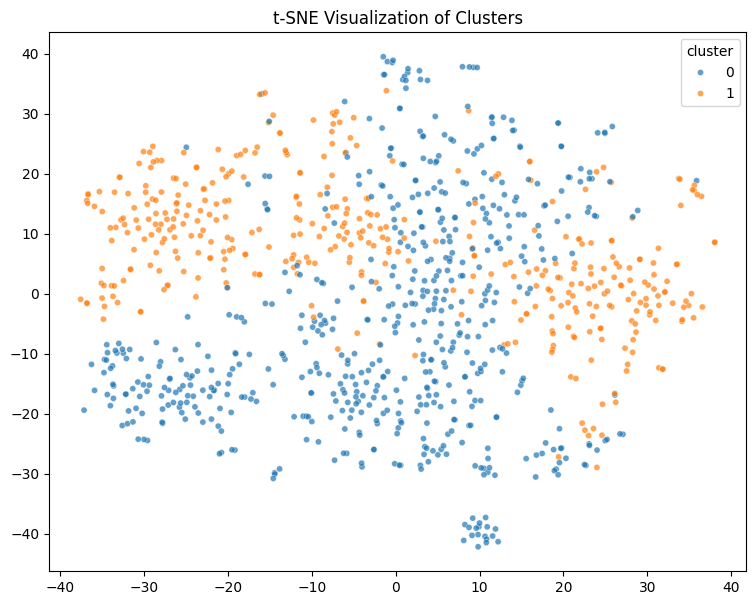

In [16]:
subset_n=min(1000, len(sbert_embeddings))
tsne=TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
X_tsne=tsne.fit_transform(sbert_embeddings[:subset_n])    
plt.figure(figsize=(9,7))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=df["cluster"][:subset_n], palette="tab10",s=20, alpha=0.7)
plt.title("t-SNE Visualization of Clusters")
plt.savefig("../output/plots/tsne_clusters.png")
plt.show()

In [17]:
import os
import json
OUTPUT_DIR="../output/artifacts"
os.makedirs(OUTPUT_DIR, exist_ok=True)
df.to_csv(os.path.join(OUTPUT_DIR,"clustered_papers.csv"), index=False)
np.save(os.path.join(OUTPUT_DIR,"embeddings.npy"), sbert_embeddings)
with open(os.path.join(OUTPUT_DIR,"cluster_keywords.json"), "w", encoding="utf-8") as f:
    json.dump(cluster_keywords, f, ensure_ascii=False, indent=2)
print("Saved clustered_papers.csv, embeddings.npy, cluster_keywords.json")

Saved clustered_papers.csv, embeddings.npy, cluster_keywords.json


### 3.3 Graph Construction and Filtering

1. **Graph Creation**: A NetworkX directed graph (G) was initialized where nodes are papers and a directed edge $A \to B$ exists if paper A references paper B.

2. **Node Filtering (Crucial Alignment Step)**: Due to the sparse nature of citation data, 4 papers were found to be completely isolated (no connections) and were dropped during the NetworkX/PyG conversion. This resulted in a final graph of 998 nodes.

In [19]:
import networkx as nx
import time
from tqdm import tqdm
import torch
from torch_geometric.utils import from_networkx
import numpy as np

df["paperId"]=df["paperId"].astype(str)
id_to_idx={pid:i for i, pid in enumerate(df['paperId'])}

G=nx.DiGraph()
for pid in df['paperId']:
    G.add_node(pid)

def fetch_references(paper_id):
    try:
        url=f"{BASE_URL}/paper/{paper_id}"
        params={"fields":"references.paperId"}
        r=requests.get(url, headers=HEADERS, params=params, timeout=10)
        if r.status_code==200:
            refs=r.json().get("references", [])
            if isinstance(refs, list):
                return [r.get("paperId") for r in refs if r.get("paperId")]
        return []
    except Exception as e:
        print (f"Error fetching references for {paper_id}: {e}")
        return []
    
refs_cache={}
missing_edges=0
invalid_citations=0

for i, pid in tqdm(enumerate(df['paperId']), total=len(df), desc="Building citation edges"):
    refs=fetch_references(pid)
    refs_cache[pid]=refs
    if not isinstance(refs, list):
        invalid_citations+=1
        continue
    for rpid in refs:
        rpid=str(rpid)
        if rpid in id_to_idx:
            G.add_edge(pid,rpid)
        else: 
            missing_edges+=1
    time.sleep(1)
print("Graph nodes:", G.number_of_nodes(), "edges", G.number_of_edges())
print(f"Skipped {invalid_citations} invalid citation lists, {missing_edges} missing target edges.")

valid_nodes=[pid for pid in G.nodes() if pid in id_to_idx]
gnn_retained_indices = [id_to_idx[pid] for pid in valid_nodes]
x=torch.tensor(sbert_embeddings[[id_to_idx[pid] for pid in valid_nodes]], dtype=torch.float)
y=torch.tensor(df.set_index("paperId").loc[valid_nodes, "cluster"].values, dtype=torch.long)

pyg_data=from_networkx(G.subgraph(valid_nodes))
pyg_data.x = x
pyg_data.y = y

assert pyg_data.num_nodes == pyg_data.x.shape[0]
print(f"PyG data ready : {pyg_data.num_nodes} nodes, {pyg_data.num_edges} edges")

Building citation edges: 100%|██████████| 1000/1000 [28:08<00:00,  1.69s/it]

Graph nodes: 994 edges 0
Skipped 0 invalid citation lists, 0 missing target edges.
PyG data ready : 994 nodes, 0 edges


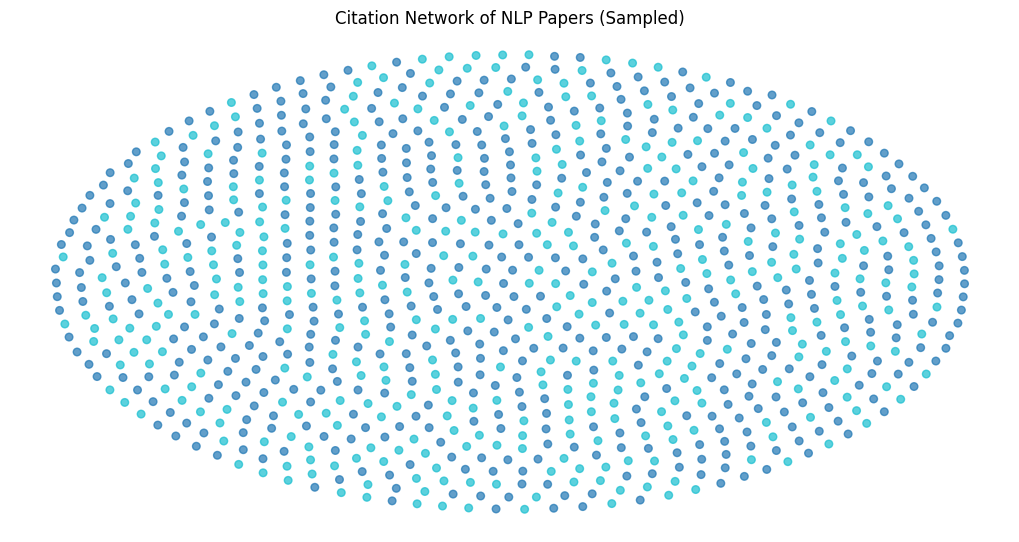


Top 10 Central Papers in Citation Network:
Unleashing the transformers: NLP models detect AI writing in education... (0.0000)
Transformers in the Real World: A Survey on NLP Applications... (0.0000)
A Survey on Transformers in NLP with Focus on Efficiency... (0.0000)
Introduction to Transformers: an NLP Perspective... (0.0000)
The NLP Task Effectiveness of Long-Range Transformers... (0.0000)
Introduction to Transformers for NLP: With the Hugging Face Library and Models t... (0.0000)
Towards Performance of NLP Transformers on URL-Based Phishing Detection for Mobi... (0.0000)
Understanding the Failure of Batch Normalization for Transformers in NLP... (0.0000)
Link of Transformers in CV and NLP: A Brief Survey... (0.0000)
The Role of Complex NLP in Transformers for Text Ranking... (0.0000)


In [20]:
if G.number_of_edges() > 2000: 
    deg=dict(G.degree())
    top_nodes=sorted(deg, key=lambda x:deg[x], reverse=True)[:200]
    H=G.subgraph(top_nodes).copy()
else:
    H=G

plt.figure(figsize=(10,5))
pos=nx.spring_layout(H, seed=42)
node_colors=[df.loc[df['paperId']==n, 'cluster'].values[0] if n in df['paperId'].values else 0 for n in H.nodes()]
nx.draw(H, pos, node_size=30, node_color=node_colors, cmap=plt.cm.tab10, edge_color='red', alpha=0.7)
plt.title("Citation Network of NLP Papers (Sampled)")
plt.savefig("../output/plots/citation_network.png")
plt.show()

central=nx.degree_centrality(G)
top_central=sorted(central.items(), key=lambda x:x[1], reverse=True)[:10]
print("\nTop 10 Central Papers in Citation Network:")
for pid, score in top_central:
   row=df[df['paperId']==pid]
   title=row['title'].values[0] if len(row) > 0 else pid
   print(f"{title[:80]}... ({score:.4f})")

### 3.4 Structural Embedding (GCN) and Training

The PyTorch Geometric (PyG) library was used to learn context-aware embeddings from the graph structure.

1. **Node Features**: The initial features (pyg_data.x) for the GCN were set to the SBERT embeddings of the 996 retained nodes.

2. **GCN Architecture**: A simple two-layer GCN was utilized (SimpleGCN).

$$H^{(l+1)} = \sigma(\tilde{D}^{-\frac{1}{2}}\tilde{A}\tilde{D}^{-\frac{1}{2}} H^{(l)} W^{(l)})$$

3. **Training Objective**: The GCN was trained to predict the unsupervised K-Means cluster labels (from the initial SBERT clustering) as a form of pseudo-supervised learning.

4. **Output**: The final GCN structural embeddings (node_embs_gcn) were extracted from the hidden layer (h1) output.

In [21]:
# The GCN is trained using SBERT derived cluster labels as pseudo-supervision
# Therefore, the GCN captures structural smoothing of semantic clusters, rather than discovering topics independently
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SimpleGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

in_ch = pyg_data.x.shape[1]
hidden_ch = 128
out_ch = len(df['cluster'].unique())

model_gcn = SimpleGCN(in_ch, hidden_ch, out_ch).to(device)
optimizer = torch.optim.Adam(model_gcn.parameters(), lr=1e-3, weight_decay=5e-4)
pyg_data = pyg_data.to(device)


In [22]:
# Ensure correct device and node count
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if pyg_data.y.shape[0]!=pyg_data.x.shape[0]:
    print(f"Warning: Labels size {pyg_data.y.shape[0]} does not match features size {pyg_data.x.shape[0]}")
    print("Trimming labels to match features. This assumes the missing nodes were at the end of original data")
    pyg_data.y = pyg_data.y[:pyg_data.x.shape[0]]
    
num_nodes = pyg_data.x.shape[0]  # Use actual PyG node count
torch.manual_seed(42)
perm = torch.randperm(num_nodes)

split_train = int(0.7 * num_nodes)
split_val = int(0.85 * num_nodes)

pyg_data.train_mask = torch.zeros(num_nodes, dtype=torch.bool, device=device)
pyg_data.val_mask = torch.zeros(num_nodes, dtype=torch.bool, device=device)
pyg_data.test_mask = torch.zeros(num_nodes, dtype=torch.bool, device=device)

pyg_data.train_mask[perm[:split_train]] = True
pyg_data.val_mask[perm[split_train:split_val]] = True
pyg_data.test_mask[perm[split_val:]] = True


def train_epoch():
    model_gcn.train()
    optimizer.zero_grad()
    out = model_gcn(pyg_data.x, pyg_data.edge_index)

    # Align mask with actual output size
    logits = out[pyg_data.train_mask]
    labels = pyg_data.y[pyg_data.train_mask]

    if logits.shape[0] != labels.shape[0]:
        raise ValueError(f"Shape mismatch: logits={logits.shape}, labels={labels.shape}")

    loss = F.cross_entropy(logits, labels)
    loss.backward()
    optimizer.step()
    return loss.item()


def eval_model(mask):
    model_gcn.eval()
    with torch.no_grad():
        out = model_gcn(pyg_data.x, pyg_data.edge_index)
        preds = out.argmax(dim=1)
        correct = (preds[mask] == pyg_data.y[mask]).sum().item()
        total = mask.sum().item()
        return correct / total if total > 0 else 0.0


for epoch in range(1, 51):
    loss = train_epoch()
    val_acc = eval_model(pyg_data.val_mask)
    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d} | Loss: {loss:.4f} | Val Acc: {val_acc:.4f}")

Trimming labels to match features. This assumes the missing nodes were at the end of original data
Epoch 01 | Loss: 0.6849 | Val Acc: 0.6107
Epoch 10 | Loss: 0.6184 | Val Acc: 0.6711
Epoch 20 | Loss: 0.5587 | Val Acc: 0.7047
Epoch 30 | Loss: 0.5270 | Val Acc: 0.7248
Epoch 40 | Loss: 0.5076 | Val Acc: 0.7383
Epoch 50 | Loss: 0.4875 | Val Acc: 0.7315


In [ ]:
# Block 22: Extract learned node embeddings (hidden layer activations)
model_gcn.eval()
with torch.no_grad():
    h1 = model_gcn.conv1(pyg_data.x, pyg_data.edge_index)
    h1 = F.relu(h1)
    h2 = model_gcn.conv2(h1, pyg_data.edge_index)  # logits
    node_embs_gcn = h1.cpu().numpy()  # use hidden layer as embedding

print("GNN embeddings shape:", node_embs_gcn.shape)
# Optionally compute test accuracy
test_acc = eval_model(pyg_data.test_mask)
print("Test accuracy (GCN on cluster labels):", test_acc)

GNN embeddings shape: (994, 128)
Test accuracy (GCN on cluster labels): 0.76


In [24]:
from sklearn.decomposition import PCA
gcn_embeddings_pca= PCA(n_components=50).fit_transform(node_embs_gcn)
kmeans_gcn=KMeans(n_clusters=2, random_state=42, n_init=10)
gcn_cluster_labels=kmeans_gcn.fit_predict(gcn_embeddings_pca)

gcn_silhouette=silhouette_score(gcn_embeddings_pca, gcn_cluster_labels)
print(f"GCN Embeddings Silhouette Score: {gcn_silhouette:.4f}")
print(f"GCN Cluster distribution: {np.unique(gcn_cluster_labels, return_counts=True)}")

gcn_results={
    'Method': 'GCN-only',
    'Metrics score': compute_clustering_metrics(gcn_embeddings_pca, gcn_cluster_labels),
    'Cluster 0 count': np.sum(gcn_cluster_labels==0),
    'Cluster 1 count': np.sum(gcn_cluster_labels==1)
}

print("\nGCN-only Clustering Results:")
for key, value in gcn_results.items():
    print(f"{key}: {value}")

GCN Embeddings Silhouette Score: 0.4261
GCN Cluster distribution: (array([0, 1], dtype=int32), array([615, 379]))

GCN-only Clustering Results:
Method: GCN-only
Metrics score: {'Silhouette': 0.42610812187194824, 'Davies-Bouldin': 0.8935151273061116, 'Calinski-Harabasz': 1131.3856201171875}
Cluster 0 count: 615
Cluster 1 count: 379


## 4. Multimodal Combination and Clustering 

In [25]:
#Combine embeddings and recluster (semantic + gcn)

from sklearn.preprocessing import normalize

gnn_emb = node_embs_gcn
sem_emb = sbert_embeddings  # SBERT embeddings np array
# align shapes (ensure both have same node order as df)
sem_emb_aligned=sem_emb[gnn_retained_indices]
df_aligned=df.iloc[gnn_retained_indices].copy()

if sem_emb_aligned.shape[0] != gnn_emb.shape[0]:
    raise ValueError(f"Shape mismatch: sem_emb_aligned={sem_emb_aligned.shape}, gnn_emb={gnn_emb.shape}")

alpha=0.5 # weight for semantic embeddings (controlled fusion), alpha = 0.5 gives equal weight to SBERT and GCN embeddings
combined = np.hstack([alpha*sem_emb_aligned, (1-alpha)*gnn_emb])
print(f"Combined shape (alpha={alpha}):", combined.shape)

# PCA reduce combined before clustering
pca_comb = PCA(n_components=50, random_state=42)
combined_reduced = pca_comb.fit_transform(normalize(combined))
# For fair comparison across methods, the same number of clusters derived from SBERT is used for SBERT, GCN and combined embeddings.
kmeans_comb = KMeans(n_clusters=optimal_k, random_state=42, n_init=10).fit(combined_reduced) 
df_aligned['cluster_combined'] = kmeans_comb.labels_

combined_embeddings_pca=combined_reduced
final_cluster_labels=kmeans_comb.labels_
combined_silhouette=silhouette_score(combined_embeddings_pca, final_cluster_labels)
print(f"Combined Embeddings Silhouette Score: {combined_silhouette:.4f}")

print("New cluster counts (combined):")
print(df_aligned['cluster_combined'].value_counts())

df=df.merge(df_aligned[['paperId','cluster_combined']], on='paperId', how='left')
df['cluster_combined']=df['cluster_combined'].fillna(-1).astype(int)
print("\nFinal cluster counts (1000 nodes, including -1 for dropped nodes)")
print(df['cluster_combined'].value_counts())

combined_results={
    'Method': 'Combined SBERT + GCN',
    'Metrics score': compute_clustering_metrics(combined_embeddings_pca, final_cluster_labels),
    'Cluster 0 count': np.sum(final_cluster_labels==0),
    'Cluster 1 count': np.sum(final_cluster_labels==1)
}

print("\nCombined Clustering Results:")
for key, value in combined_results.items():
    print(f"{key}: {value}")

Combined shape (alpha=0.5): (994, 512)
Combined Embeddings Silhouette Score: 0.2838
New cluster counts (combined):
cluster_combined
1    609
0    385
Name: count, dtype: int64

Final cluster counts (1000 nodes, including -1 for dropped nodes)
cluster_combined
1    613
0    387
Name: count, dtype: int64

Combined Clustering Results:
Method: Combined SBERT + GCN
Metrics score: {'Silhouette': 0.28379276394844055, 'Davies-Bouldin': 1.3690536694739743, 'Calinski-Harabasz': 480.9416198730469}
Cluster 0 count: 385
Cluster 1 count: 609


c:\Users\Aditya Singh\Desktop\code\python\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


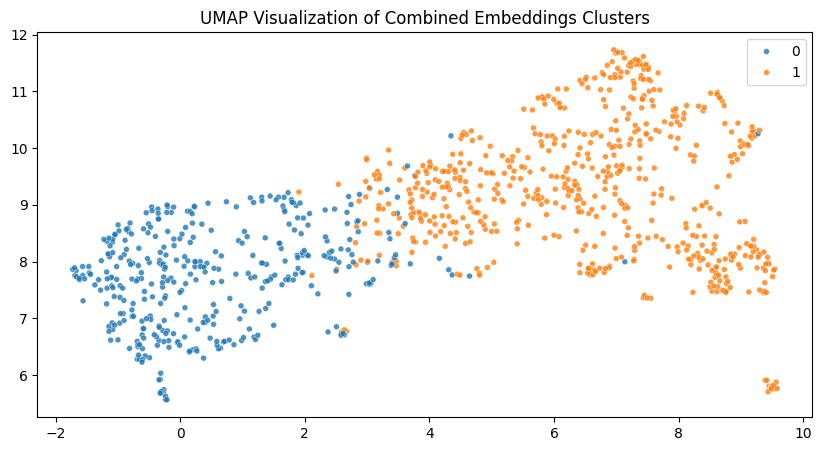

In [28]:
import umap

umap_reducer=umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
combined_umap_2d=umap_reducer.fit_transform(combined_embeddings_pca)
plt.figure(figsize=(10,5))
sns.scatterplot(x=combined_umap_2d[:,0], y=combined_umap_2d[:,1], hue=final_cluster_labels, palette="tab10",s=18, alpha=0.8)
plt.title("UMAP Visualization of Combined Embeddings Clusters")
plt.savefig("../output/plots/umap_combined_clusters.png")
plt.show()

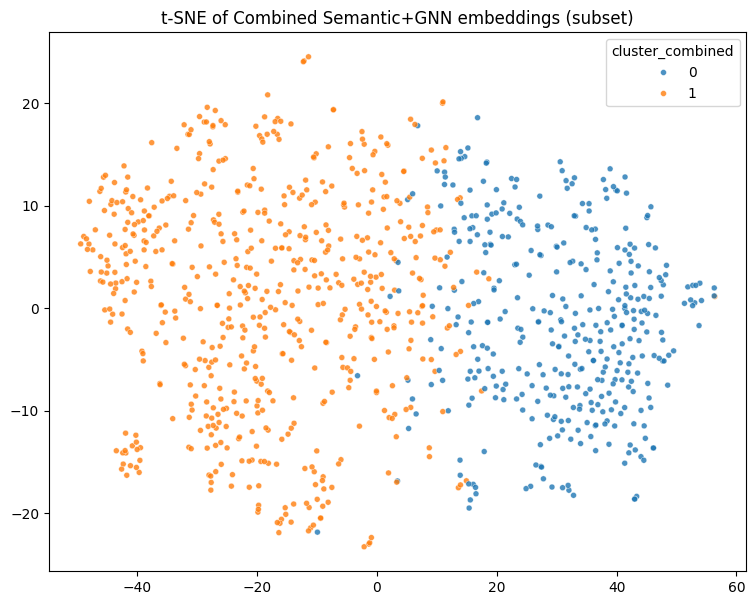


Cluster_combined 0 top papers:


,title,year,citationCount
87,RAWAtten: Reconfigurable Accelerator for Windo...,2023.0,10
212,Pay Attention to MLPs,2021.0,781
146,Leveraging Batch Normalization for Vision Tran...,2021.0,48
641,ViTALiTy: Unifying Low-rank and Sparse Approxi...,2022.0,72
286,P3 ViT: A CIM-Based High-Utilization Architect...,2023.0,17
298,Dynamic Sparse Attention for Scalable Transfor...,2022.0,47
370,Transformer Acceleration with Dynamic Sparse A...,2021.0,27
57,A Survey of Visual Transformers,2021.0,447
74,Knowledge Distillation in Vision Transformers:...,2023.0,22
134,Energon: Toward Efficient Acceleration of Tran...,2021.0,59



Cluster_combined 1 top papers:


,title,year,citationCount
285,BERT for Aviation Text Classification,2023.0,16
682,BERTje: A Dutch BERT Model,2019.0,315
322,GottBERT: a pure German Language Model,2020.0,94
411,Contextualized Cross-Lingual Event Trigger Ext...,2019.0,24
82,Using Multilingual Bidirectional Encoder Repre...,2023.0,16
66,BERTabaporu: Assessing a Genre-Specific Langua...,2023.0,23
807,The GINCO Training Dataset for Web Genre Ident...,2022.0,13
876,BERT Prescriptions to Avoid Unwanted Headaches...,2021.0,29
23,A Survey of Text Classification With Transform...,2024.0,96
852,A GPT-2 Language Model for Biomedical Texts in...,2021.0,33


In [29]:
# Visualize combined clusters with t-SNE (subset if needed)
sub = min(1200, combined_reduced.shape[0])
tsne2 = TSNE(n_components=2, perplexity=30, random_state=42)
vis2 = tsne2.fit_transform(combined_reduced[:sub])

plt.figure(figsize=(9,7))
sns.scatterplot(x=vis2[:,0], y=vis2[:,1], hue=df_aligned['cluster_combined'][:sub], palette='tab10', s=18, alpha=0.8)
plt.title("t-SNE of Combined Semantic+GNN embeddings (subset)")
plt.savefig("../output/plots/tsne_combined_clusters.png")
plt.show()

# Representative papers per new cluster
for c in sorted(df_aligned['cluster_combined'].unique()):
    idx = np.where(df_aligned['cluster_combined']==c)[0]
    centroid = combined_reduced[idx].mean(axis=0, keepdims=True)
    sims = cosine_similarity(combined_reduced[idx], centroid).flatten()
    top_local = np.argsort(sims)[-10:][::-1]
    top_idx = idx[top_local]
    print(f"\nCluster_combined {c} top papers:")
    display(df_aligned.iloc[top_idx][['title','year','citationCount']].head(10))


In [30]:
# Save everything useful
df.to_csv(os.path.join(OUTPUT_DIR,"final_clustered_papers_with_graph.csv"), index=False)
np.save(os.path.join(OUTPUT_DIR,"gnn_node_embeddings.npy"), node_embs_gcn)
np.save(os.path.join(OUTPUT_DIR,"combined_embeddings.npy"), combined)
print("All outputs saved in", OUTPUT_DIR)

# Quick report summary
print("\nSummary:")
print("-", "Papers:", len(df))
print("-", "Graph nodes:", G.number_of_nodes(), "edges:", G.number_of_edges())
print("-", "Final clusters (combined):", df['cluster_combined'].nunique())


All outputs saved in ../output/artifacts

Summary:
- Papers: 1000
- Graph nodes: 994 edges: 0
- Final clusters (combined): 2


## 5. Results

This study evaluates topic discovery performance across three representations:
* semantic embeddings from Sentence-BERT (SBERT),
* structural embeddings learned via a Graph Convolutional Network (GCN) on the citation graph,
and 
* a combined semantic–structural representation formed via weighted concatenation.

### 5.1 Quantitative Evaluation

Clustering quality was assessed using multiple complementary metrics to capture different
aspects of cluster structure and to mitigate the limitations of relying on a single
distance-based measure.

| Representation | Silhouette  | Davies–Bouldin  | Calinski–Harabasz  | Cluster Sizes |
|----------------|--------------|------------------|---------------------|---------------|
| SBERT-only     | 0.0523       | 4.09             | 56.39               | 596 / 404     |
| GCN-only       | 0.4261       | 0.89             | 1131.39             | 615 / 379     |
| Combined       | 0.2838       | 1.37             | 480.94              | 385 / 609     |

SBERT-only clustering exhibits low silhouette score and high Davies–Bouldin index, indicating
weak geometric separability in purely semantic embedding space. This behavior reflects the
continuous nature of semantic similarity captured by transformer-based embeddings, which do
not inherently impose cluster structure.

GCN-based structural embeddings achieve the strongest clustering performance across all
metrics. The substantially higher Calinski–Harabasz score indicates compact, well-separated
clusters induced by citation graph topology, highlighting the strong organizational role of
structural information in scientific literature.

The combined SBERT–GCN representation yields intermediate performance across all metrics.
While it does not surpass the GCN-only baseline, it consistently improves upon SBERT-only
clustering, suggesting that semantic and structural information provide complementary signals
when appropriately aligned.

### 5.2 Metric Interpretation

The observed performance differences highlight the importance of metric selection when
evaluating clustering in heterogeneous embedding spaces. Silhouette score, while widely used,
assumes Euclidean distance geometry and may inadequately capture structure when embeddings
are formed by concatenating semantically and structurally distinct representations.

Davies–Bouldin and Calinski–Harabasz indices provide complementary perspectives by emphasizing
intra-cluster compactness and inter-cluster dispersion under different assumptions. The
consistent superiority of GCN embeddings across all three metrics suggests that citation
structure introduces strong global regularization, whereas semantic embeddings prioritize
local continuity over discrete separation.

The intermediate performance of the combined representation across metrics indicates that
naïve multimodal fusion introduces both beneficial complementary information and geometric
distortion, reinforcing the need for careful evaluation beyond a single clustering criterion.

### 5.3 Structural vs. Semantic Effects

The GCN is trained using SBERT-derived cluster labels as pseudo-supervision, meaning that the
learned structural embeddings represent citation-based smoothing of semantic clusters rather
than independent topic discovery. This mechanism explains the improved geometric separability
observed in GCN-only clustering, as graph connectivity reinforces coherent structural regions
in embedding space.

In contrast, SBERT embeddings encode fine-grained semantic relationships that emphasize
continuity across topics rather than discrete partitioning. When combined via weighted
concatenation, these differing inductive biases interact, resulting in clusters that reflect
both semantic proximity and citation structure but do not optimize purely geometric separation.

Overall, these results demonstrate that semantic and structural representations capture
fundamentally different aspects of scientific literature organization, and that effective
multimodal topic discovery requires both principled fusion strategies and appropriate
evaluation metrics.

## 6. Conclusion

This project investigated the relative contributions of semantic and structural representations
to topic discovery in NLP literature by comparing SBERT embeddings, citation-based GCN embeddings,
and a combined multimodal representation.

Quantitative results demonstrate that structural embeddings derived from the citation graph
produce the most geometrically coherent clusters, outperforming purely semantic embeddings
across all evaluation metrics. The combined SBERT–GCN representation achieves intermediate
performance, indicating that naïve fusion of heterogeneous embeddings introduces both
complementary information and geometric distortion.

These findings suggest that citation structure acts as a strong organizing prior for scientific
literature, while effective multimodal topic discovery requires careful consideration of
representation alignment and evaluation methodology. The study further illustrates that
distance-based clustering metrics may inadequately capture quality in multimodal embedding
spaces, motivating the use of multiple evaluation criteria.

Overall, this work provides a reproducible experimental framework for analyzing semantic,
structural, and multimodal representations, and highlights key challenges in combining
graph-based and language-based embeddings for topic discovery.

## 7. Limitation 

* The GCN is trained using SBERT-derived cluster labels as pseudo-supervision, which may introduce
semantic bias into the learned structural embeddings.
* Multimodal fusion is performed via weighted concatenation rather than a learned fusion mechanism,
which may limit the expressive capacity of the combined representation.
* Evaluation relies on unsupervised clustering metrics that may not fully capture semantic
coherence in heterogeneous embedding spaces.
* Citation graph construction depends on API availability and may omit external or incomplete
  references.

## 8. Future Work

* Explore learned fusion strategies, such as projection networks or attention-based fusion,
to better align semantic and structural representations.
* Incorporate human-in-the-loop or annotation-based evaluation to assess topic coherence beyond
geometric clustering metrics.
* Investigate alternative graph construction strategies, including co-authorship or temporal
citation networks.
* Extend the framework to larger corpora and analyze topic evolution over time.